In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import chirp, correlate
import scipy.io.wavfile as wavfile
import wave

## Generate Logarithmic Chirp Signal as Test Signal

In [3]:
def generate_log_chirp(duration=1.0, fs=48000, f0=100, f1=8000):
    """
    Generate a logarithmic chirp signal.
    
    Parameters:
        duration (float): Length of chirp in seconds.
        fs (int): Sampling rate in Hz.
        f0 (int): Start frequency in Hz.
        f1 (int): End frequency in Hz.
    
    Returns:
        t (numpy array): Time axis.
        chirp_signal (numpy array): Logarithmic chirp signal.
    """
    t = np.linspace(0, duration, int(fs * duration), endpoint=False)
    chirp_signal = chirp(t, f0=f0, f1=f1, t1=duration, method='logarithmic')
    
    return t, chirp_signal

def apply_time_delay(signal, fs, delay_sec):
    """
    Apply a time delay to a signal by shifting it in time.

    Parameters:
        signal (numpy array): Input signal.
        fs (int): Sampling rate in Hz.
        delay_sec (float): Delay in seconds.

    Returns:
        delayed_signal (numpy array): Time-shifted signal.
    """
    delay_samples = int(delay_sec * fs)  # Convert seconds to samples
    delayed_signal = np.roll(signal, delay_samples)
    
    # Zero out the first `delay_samples` to simulate real delay
    delayed_signal[:delay_samples] = 0  

    return delayed_signal

def generate_stereo_chirp(duration=1.0, fs=48000, f0=100, f1=8000, delay_sec=0.05):
    """
    Generate a stereo chirp where the right channel is a delayed version of the left.

    Parameters:
        duration (float): Length of chirp in seconds.
        fs (int): Sampling rate in Hz.
        f0 (int): Start frequency in Hz.
        f1 (int): End frequency in Hz.
        delay_sec (float): Delay applied to right channel.

    Returns:
        stereo_signal (numpy array): Stereo signal (2 x N).
    """
    t, chirp_signal = generate_log_chirp(duration, fs, f0, f1)
    delayed_signal = apply_time_delay(chirp_signal, fs, delay_sec)

    # Create a stereo signal: Left = Reference, Right = Delayed
    stereo_signal = np.vstack((chirp_signal, delayed_signal)).T

    return stereo_signal



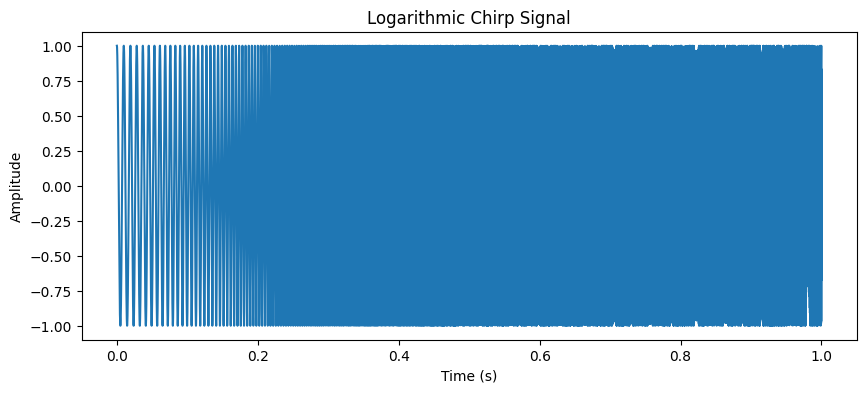

In [4]:

# Generate and plot the chirp signal
fs = 22050  # Sampling rate
#fs = 16000  # Sampling rate
t, chirp_signal = generate_log_chirp(duration=1.0, fs=fs, f0=100, f1=8000)

plt.figure(figsize=(10, 4))
plt.plot(t, chirp_signal)
plt.title("Logarithmic Chirp Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

In [5]:
def save_wav(filename, signal, fs):
    """
    Save an audio signal as a WAV file.

    Parameters:
        filename (str): Output file name (e.g., 'test_signal.wav').
        signal (numpy array): Audio signal data (mono or stereo).
        fs (int): Sampling rate in Hz.
    """
    # Normalize to 16-bit PCM format
    signal_int16 = np.int16(signal * 32767)

    wavfile.write(filename, fs, signal_int16)
    print(f"Saved: {filename}")

#### Generate WAV files

(16kHz,10sec) 

Mono: "chirp_mono.wav" chirp from 100Hz to 7kHz

Stereo: "chirp_stereo.wav" Channel 0: equal to Mono Chirp, Channel 1: Mono Channel delayed by 100 ms

In [6]:
fs = 22050  # Sampling rate
t = 10. # 10 sec
_, chirp_signal_wav = generate_log_chirp(duration=t, fs=fs, f0=100, f1=7000)

# Save the mono chirp
save_wav(f"chirp_mono_{fs}.wav", chirp_signal_wav, fs)

# Generate and save stereo chirp
stereo_chirp = generate_stereo_chirp(duration=t, fs=fs, delay_sec=0.1)
save_wav(f"chirp_stereo_{fs}.wav", stereo_chirp, fs)


Saved: chirp_mono_22050.wav
Saved: chirp_stereo_22050.wav


In [9]:
!scp chirp_stereo_22050.wav jetson:~/
!ssh jetson aplay chirp_stereo_22050.wav

chirp_stereo_22050.wav                        100%  861KB  19.7MB/s   00:00    
Playing WAVE 'chirp_stereo_22050.wav' : Signed 16 bit Little Endian, Rate 22050 Hz, Stereo


## Delay Estimation

In [3]:
def estimate_time_delay(reference_signal, delayed_signal, fs):
    """
    Estimate time delay using cross-correlation.

    Parameters:
        reference_signal (numpy array): Original signal.
        delayed_signal (numpy array): Delayed version of the signal.
        fs (int): Sampling rate in Hz.

    Returns:
        estimated_delay_sec (float): Estimated delay in seconds.
    """
    correlation = correlate(delayed_signal, reference_signal, mode="full")
    delay_samples = np.argmax(correlation) - len(reference_signal) + 1
    estimated_delay_sec = delay_samples / fs
    
    return estimated_delay_sec, correlation

### Simulation

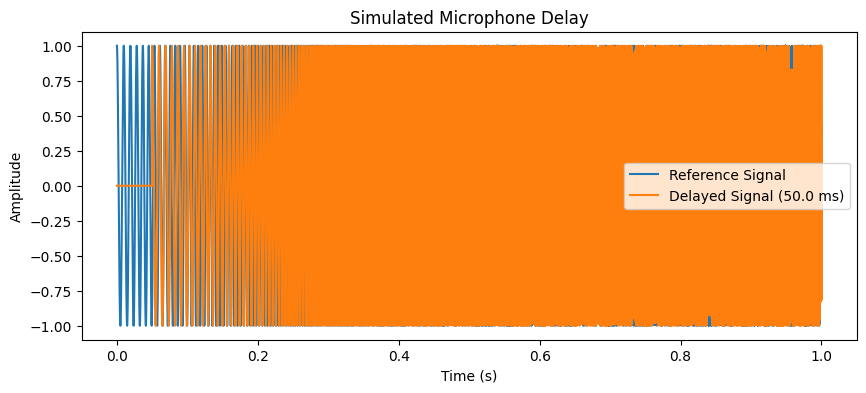

In [97]:
# Apply a 50 ms delay
delay_sec = 0.05  # 50 milliseconds
mic_signal = apply_time_delay(chirp_signal, fs, delay_sec)

# Plot the delayed signal
plt.figure(figsize=(10, 4))
plt.plot(t, chirp_signal, label="Reference Signal")
plt.plot(t, mic_signal, label=f"Delayed Signal ({delay_sec * 1000:.1f} ms)")
plt.title("Simulated Microphone Delay")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

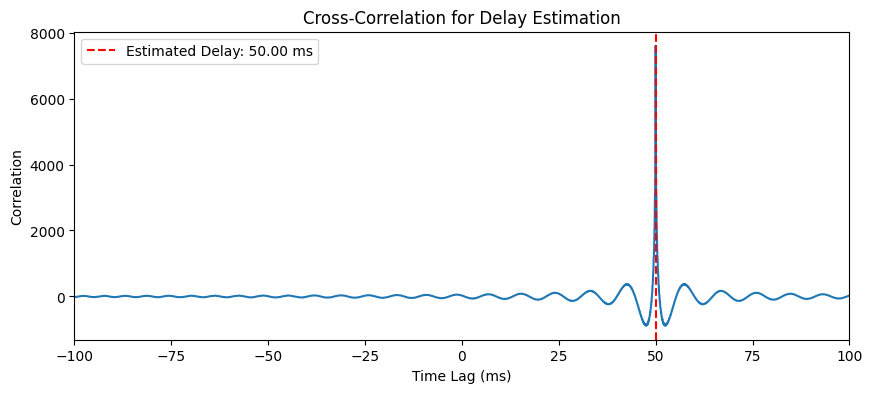

Estimated Time Delay: 50.00 ms


In [99]:
# Estimate the delay
estimated_delay_sec, correlation = estimate_time_delay(chirp_signal, mic_signal, fs)

# Plot the cross-correlation
lags = np.arange(-len(chirp_signal) + 1, len(chirp_signal)) / fs

plt.figure(figsize=(10, 4))
plt.plot(lags * 1000, correlation)
plt.axvline(x=estimated_delay_sec * 1000, color='r', linestyle='--', label=f"Estimated Delay: {estimated_delay_sec * 1000:.2f} ms")
plt.title("Cross-Correlation for Delay Estimation")
plt.xlabel("Time Lag (ms)")
plt.ylabel("Correlation")
plt.xlim((-100,100))
plt.legend()
plt.show()

print(f"Estimated Time Delay: {estimated_delay_sec * 1000:.2f} ms")


## Measurement

In [ ]:
#!scp jetson:~/chirp_record_22050_docker.wav .

chirp_record_22050_docker.wav                 100% 3469KB  32.7MB/s   00:00    


In [21]:
def read_wav_wave(filename):
    """
    Read a WAV file using the `wave` module and return its data as a NumPy array.

    Parameters:
        filename (str): Path to the WAV file.

    Returns:
        fs (int): Sampling rate in Hz.
        audio_data (numpy array): Audio data with shape (Samples, Channels).
    """
    with wave.open(filename, "rb") as wf:
        num_channels = wf.getnchannels()
        sample_width = wf.getsampwidth()
        fs = wf.getframerate()
        num_frames = wf.getnframes()
        
        print(f"Channels: {num_channels}, Sample Width: {sample_width} bytes, Sample Rate: {fs} Hz, Frames: {num_frames}")

        # Read raw audio data
        raw_data = wf.readframes(num_frames)

        # Convert raw bytes to NumPy array
        audio_data = np.frombuffer(raw_data, dtype=np.int16)  # 16-bit PCM

        # Reshape if multichannel
        if num_channels > 1:
            audio_data = audio_data.reshape(-1, num_channels)

        return fs, audio_data

# Load and print WAV file details
fs, audio_data = read_wav_wave("/Users/mischa/Projects/AEC/chirp_mono_mac_os/expl_chirp_mono_delay_0ms__2.wav")
print(f"Audio Shape: {audio_data.shape}")  # (Samples, Channels)


Channels: 6, Sample Width: 2 bytes, Sample Rate: 16000 Hz, Frames: 170081
Audio Shape: (170081, 6)


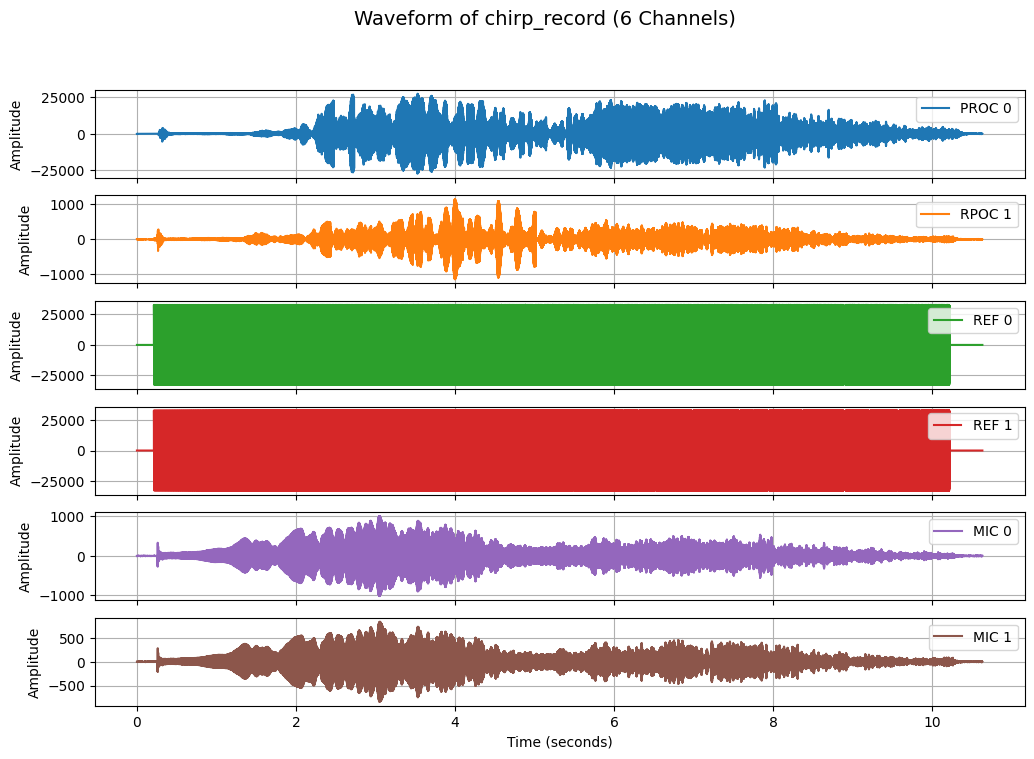

In [22]:

channel_names = [
    "PROC 0",
    "RPOC 1",
    "REF 0",
    "REF 1",
    "MIC 0",
    "MIC 1"
]
num_samples, num_channels = audio_data.shape if len(audio_data.shape) > 1 else (len(audio_data), 1)

# Create time axis
time_axis = np.linspace(0, num_samples / fs, num=num_samples)

# Limit to first 6 channels for plotting
num_channels_to_plot = min(num_channels, 6)

# Create subplots
fig, axes = plt.subplots(num_channels_to_plot, 1, figsize=(12, 8), sharex=True)
fig.suptitle(f"Waveform of chirp_record ({num_channels} Channels)", fontsize=14)

if num_channels_to_plot == 1:
    axes = [axes]  # Ensure axes is iterable for mono files

# Plot each channel separately
for i in range(num_channels_to_plot):
    axes[i].plot(time_axis, audio_data[:, i], label=f"{channel_names[i]}", color=f"C{i}")
    axes[i].set_ylabel("Amplitude")
    axes[i].legend(loc="upper right")
    axes[i].grid(True)

# Set common labels
axes[-1].set_xlabel("Time (seconds)")

plt.show()



sample-rate: 16000


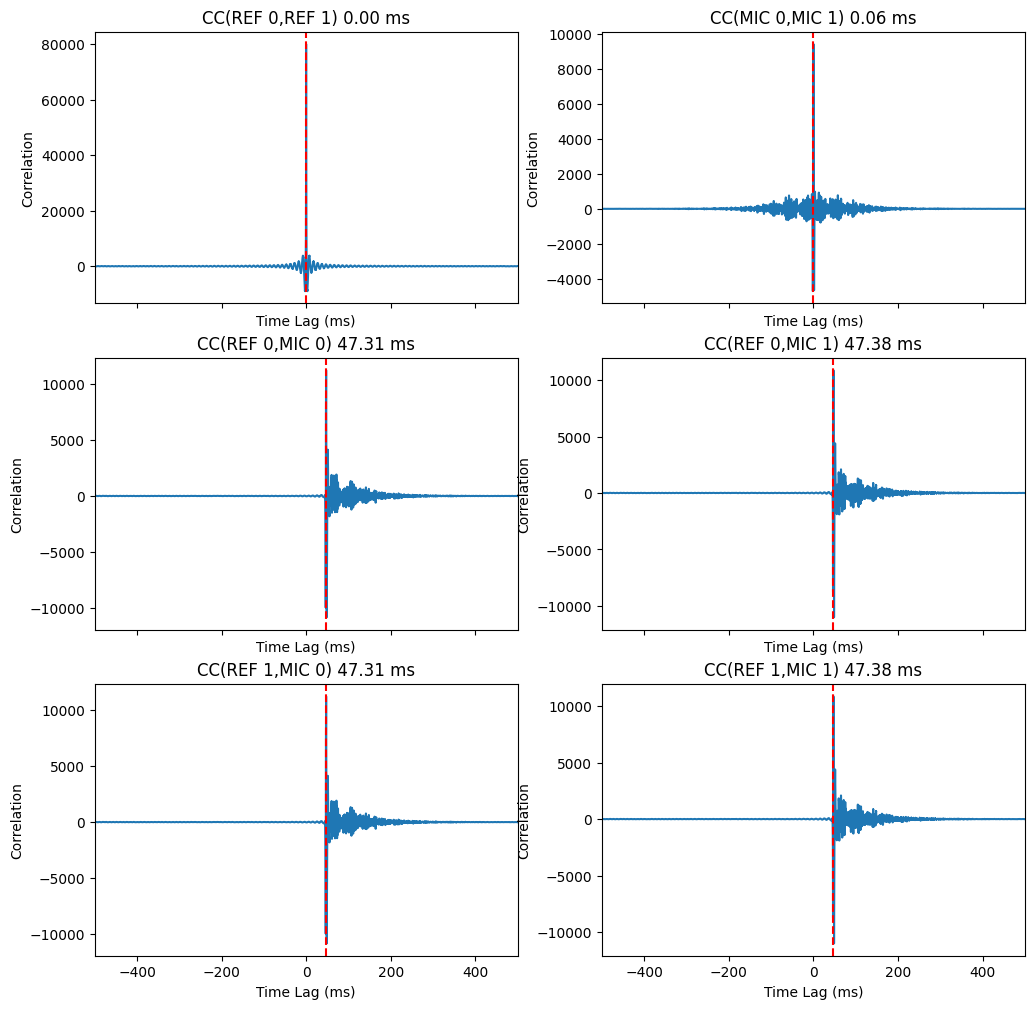

In [23]:
print( f"sample-rate: {fs}" )
combinations = ((2,3),(4,5),(2,4),(2,5),(3,4),(3,5))
fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharex=True)
axes = axes.flatten()
for i, comb in enumerate(combinations):
    chirp_signal = audio_data[:,comb[0]] / np.max(audio_data[:,comb[0]])
    mic_signal = audio_data[:,comb[1]] / np.max(audio_data[:,comb[1]])
    # Estimate the delay
    estimated_delay_sec, correlation = estimate_time_delay(chirp_signal, mic_signal, fs)
    # Plot the cross-correlation
    lags = np.arange(-len(chirp_signal)+ 1, len(chirp_signal)) / fs

    axes[i].plot(lags * 1000, correlation)
    axes[i].axvline(x=estimated_delay_sec * 1000, color='r', linestyle='--', label=f"Estimated Delay: {estimated_delay_sec * 1000:.2f} ms")
    axes[i].set_title(f"CC({channel_names[comb[0]]},{channel_names[comb[1]]}) {estimated_delay_sec * 1000:.2f} ms")
    axes[i].set_xlabel("Time Lag (ms)")
    axes[i].set_ylabel("Correlation")
    axes[i].set_xlim((-500,500))